## WEIGHT REPRESENTATION

## AIM OF THE NOTEBOOK
1. Take the models and get weights keys and values
2. Plot the distribution of weights for all 192 parameters
3. Do a statistical test    

In [1]:
from t5_WGQA_final import convert_t5_to_wgqa
from transformers import T5ForConditionalGeneration
import torch
import numpy as np

def load_model(checkpoint_path:str,model_type:str="WGQA"):
    t5: T5ForConditionalGeneration = T5ForConditionalGeneration.from_pretrained("t5-small")

    if model_type == "WGQA":
        t5_finetuned = convert_t5_to_wgqa(t5,kv_heads=4,weight_flag=True,if_random=False)
    elif model_type == 'RANDWGQA':
        t5_finetuned = convert_t5_to_wgqa(t5,kv_heads=4,weight_flag=True,if_random=True)

    del t5

    t5_finetuned.load_state_dict(torch.load(checkpoint_path))
    weight_vec = []
    for param in t5_finetuned.parameters():
        sh = param.shape
        if len(sh)==2 and sh[0]==8 and sh[1]==1:
            weight_vec.append(param)
    del t5_finetuned
    weights = torch.cat(weight_vec,0)
    weights = np.array(weights.detach()).tolist()
    weight_list = [i[0] for i in weights]
    return weight_list

In [48]:
weights = load_model("MODEL/wgqa_t5_finetuned_epoch_2.pth")

In [3]:
import os
import pandas as pd
from tqdm import tqdm

weight_dict = {}

for model in tqdm(os.listdir("MODEL2")):
    load_model_name = model
    if "steps" in model:
        model_list = model.split(".")
        model = model_list[0].split("_")[-1]
        model = "STEPS "+model
    if "epoch" in model:
        model_list = model.split(".")
        model = model_list[0].split("_")[-1]
        model = "EPOCH "+model
        
    weights = load_model(os.path.join("MODEL2",load_model_name))
    weight_dict[model] = weights

100%|██████████| 3/3 [00:06<00:00,  2.26s/it]


In [4]:
df = pd.DataFrame.from_dict(weight_dict)

In [5]:
df

,EPOCH 0,EPOCH 2,EPOCH 1
0,0.773353,0.618381,0.639364
1,-0.226863,-0.158829,-0.153211
2,0.620368,0.576257,0.579808
3,-0.069378,-0.057781,-0.045794
4,-0.028164,-0.013435,-0.003727
...,...,...,...
187,-0.294206,-0.333615,-0.321852
188,1.702690,1.916499,1.885926
189,-0.064404,-0.085597,-0.082654
190,-0.509038,-0.418195,-0.393896


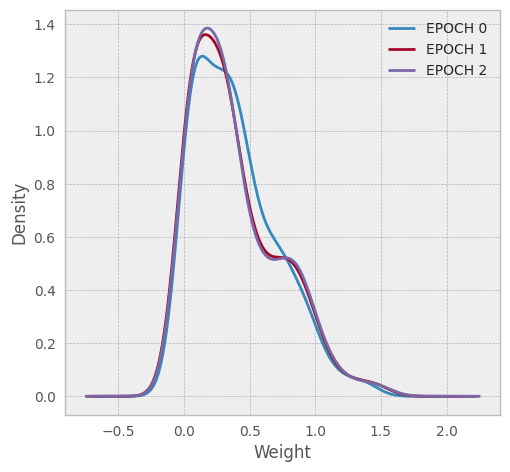

In [142]:
import matplotlib.pyplot as plt

plt.style.use('bmh')
df[['EPOCH 0','EPOCH 1','EPOCH 2']].plot.kde(figsize=(5,5),)
# df[['STEPS 20000','STEPS 22000','STEPS 24000','STEPS 26000','EPOCH 2']].plot.kde(figsize=(5,5),)
# plt.axvline(0.2,)
plt.xlabel("Weight");

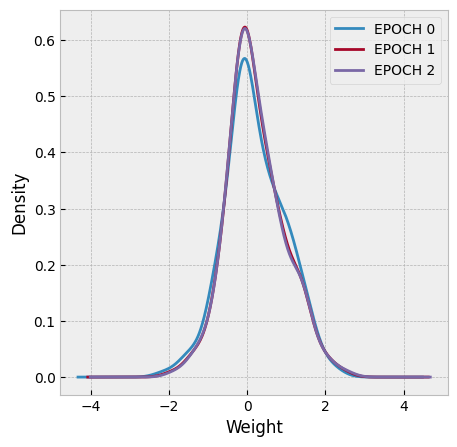

In [6]:
import matplotlib.pyplot as plt

plt.style.use('bmh')
df[['EPOCH 0','EPOCH 1','EPOCH 2']].plot.kde(figsize=(5,5),)
# df[['STEPS 20000','STEPS 22000','STEPS 24000','STEPS 26000','EPOCH 2']].plot.kde(figsize=(5,5),)
# plt.axvline(0.2,)
plt.xlabel("Weight");

In [143]:
best_epoch_df = df[['STEPS 20000','STEPS 22000','STEPS 24000','STEPS 26000','EPOCH 2']]

In [144]:
weight_lists = []
cols = best_epoch_df.columns.tolist()
for col in cols:
    weight_lists.append(df[col].values.tolist())

In [145]:
len(weight_lists)

5

In [146]:
from scipy import stats

# Significance level (adjust as needed)
alpha = 0.05

# Perform one-sample t-test for each group
for i, weights in enumerate(weight_lists):
    # Perform one-sample t-test
    t_statistic, p_value = stats.ttest_1samp(weights, 0.5)

    # Print the results
    print(f"Group {i}:")
    print("T-statistic:", t_statistic)
    print("P-value:", p_value)

    # Check the significance
    if p_value < alpha:
        print("Null Hypothesis rejected")
    else:
        print("Can't reject null hypothesis")
    
    print("\n")

Group 0:
T-statistic: -4.76184717294398
P-value: 3.783384155275886e-06
Null Hypothesis rejected


Group 1:
T-statistic: -4.718585220687566
P-value: 4.579549338116404e-06
Null Hypothesis rejected


Group 2:
T-statistic: -4.651984499722356
P-value: 6.129803339993824e-06
Null Hypothesis rejected


Group 3:
T-statistic: -4.612286219956974
P-value: 7.282907373697643e-06
Null Hypothesis rejected


Group 4:
T-statistic: -4.605130962937041
P-value: 7.5118689000325204e-06
Null Hypothesis rejected


